In [15]:
import numpy as np
import matplotlib.pyplot as plt
from Bio.Align import substitution_matrices
from matplotlib.patches import Rectangle
from matplotlib.colors import Normalize, LinearSegmentedColormap

In [16]:
def get_blosum_score(a, b, matrix):
    """Return BLOSUM62 score for amino acid pair (a, b) using provided matrix."""
    return matrix.get((a, b), matrix.get((b, a), -4))

In [17]:
def traceback(score_matrix, traceback_matrix, i, j, seq):
    """Perform traceback from given position to find alignment path."""
    path_a, path_b = [], []
    while i > 0 and j > 0 and score_matrix[i][j] != 0:
        path_a.append(i - 1)
        path_b.append(j - 1)
        direction = traceback_matrix[i][j]
        if direction == 1:  # Diagonal (match)
            i -= 1
            j -= 1
        elif direction == 2:  # Up (gap in seq2)
            i -= 1
        elif direction == 3:  # Left (gap in seq1)
            j -= 1
    return (
        min(path_a), max(path_a),
        min(path_b), max(path_b),
        ''.join([seq[pos] for pos in reversed(path_a)]),
        ''.join([seq[pos] for pos in reversed(path_b)])
    )

In [18]:
def find_repeats(seq, gap_penalty=-8, min_score=15, allow_overlap=True):
    """Find repeating patterns using Smith-Waterman local alignment."""
    if len(seq) < 2:
        return []

    matrix = substitution_matrices.load("BLOSUM62")
    n = len(seq)
    score_matrix = np.zeros((n + 1, n + 1))
    traceback_matrix = np.zeros((n + 1, n + 1), dtype=int)
    high_scores = []

    # Precompute BLOSUM scores
    aa_pairs = {(seq[i], seq[j]) for i in range(n) for j in range(n)}
    precomputed_scores = {(a, b): get_blosum_score(a, b, matrix) for a, b in aa_pairs}

    # Fill scoring matrix
    for i in range(1, n + 1):
        for j in range(1, n + 1):
            if i == j: continue  # Skip self-alignment
            match = score_matrix[i-1][j-1] + precomputed_scores[(seq[i-1], seq[j-1])]
            delete = score_matrix[i-1][j] + gap_penalty
            insert = score_matrix[i][j-1] + gap_penalty
            scores = [0, match, delete, insert]
            best_score = max(scores)
            best_dir = np.argmax(scores)

            score_matrix[i][j] = best_score
            traceback_matrix[i][j] = best_dir

            if best_score >= min_score:
                high_scores.append((best_score, i, j))

    # Process high scores
    high_scores.sort(reverse=True, key=lambda x: x[0])
    repeats = []
    seen = set()

    for score, i, j in high_scores:
        start1, end1, start2, end2, seg1, seg2 = traceback(
            score_matrix, traceback_matrix, i, j, seq)

        if not allow_overlap and not (end1 < start2 or end2 < start1):
            continue

        key = tuple(sorted([(seg1, start1, end1), (seg2, start2, end2)]))
        if key not in seen:
            seen.add(key)
            repeats.append({
                'score': score,
                'segments': [(start1, end1, seg1), (start2, end2, seg2)]
            })

    return repeats

In [19]:
def print_repeats(repeats):
    """Print identified repeats in readable format."""
    if not repeats:
        print("No significant repeats found")
        return

    for i, rep in enumerate(repeats, 1):
        print(f"Repeat {i}: Score = {rep['score']:.1f}")
        for seg in rep['segments']:
            print(f"  Segment {seg[0]}-{seg[1]}: {seg[2]}")
        print()

In [20]:
def plot_repeats(repeats, sequence):
    """Visualize repeats using an enhanced symmetric dot plot."""
    if not sequence:
        raise ValueError("Empty sequence provided")
    if not repeats:
        print("No repeats to visualize")
        return

    plt.figure(figsize=(12, 12), dpi=100)
    ax = plt.gca()
    seq_len = len(sequence)

    # Create colormap with modern colors
    colors = ['#ffffff', '#fff7fb', '#ece7f2', '#d0d1e6', '#a6bddb', 
              '#74a9cf', '#3690c0', '#0570b0', '#045a8d', '#023858']
    cmap = LinearSegmentedColormap.from_list("cool_cmap", colors)
    max_score = max(r['score'] for r in repeats) or 1
    norm = Normalize(vmin=0, vmax=max_score)

    # Configure grid and labels
    ax.plot([0, seq_len], [0, seq_len], color='#2b8cbe', lw=1.5, alpha=0.7)
    ax.set_xticks(np.arange(seq_len) + 0.5, minor=True)
    ax.set_yticks(np.arange(seq_len) + 0.5, minor=True)
    ax.set_xticklabels(list(sequence), minor=True, fontsize=8, rotation=90, color='#253494')
    ax.set_yticklabels(list(sequence), minor=True, fontsize=8, color='#253494')
    ax.grid(which='minor', color='#f0f0f0', ls='--', lw=0.7)

    # Remove major ticks
    ax.tick_params(which='major', length=0)
    ax.set_xticks([])
    ax.set_yticks([])

    # Add semi-transparent background
    ax.set_facecolor('#fafafa')

    # Sort repeats by score (ascending) so that higher scores are drawn last (on top)
    sorted_repeats = sorted(repeats, key=lambda rep: rep['score'])

    # Plot repeats with adjusted transparency and z-order
    for rep in sorted_repeats:
        (s1, e1, seg1), (s2, e2, seg2) = rep['segments']
        # Main rectangle
        rect = Rectangle(
            (s1, s2), e1 - s1 + 1, e2 - s2 + 1,
            linewidth=0.5, edgecolor='white',
            facecolor=cmap(norm(rep['score'])), alpha=0.6,
            zorder=rep['score']
        )
        ax.add_patch(rect)
        # Mirror rectangle (if not on the diagonal)
        if s1 != s2:
            mirror_rect = Rectangle(
                (s2, s1), e2 - s2 + 1, e1 - s1 + 1,
                linewidth=0.5, edgecolor='white',
                facecolor=cmap(norm(rep['score'])), alpha=0.6,
                zorder=rep['score']
            )
            ax.add_patch(mirror_rect)

    # Configure plot limits and style
    ax.set(xlim=(0, seq_len), ylim=(0, seq_len), aspect='equal')
    ax.invert_yaxis()
    ax.set_xlabel('Sequence Position (i)', fontsize=12, labelpad=15, color='#2c7fb8')
    ax.set_ylabel('Sequence Position (j)', fontsize=12, labelpad=15, color='#2c7fb8')
    ax.set_title('Protein Repeat Analysis\nBLOSUM62 Local Alignment',
                 fontsize=14, pad=20, color='#2c7fb8', weight='semibold')

    # Add colorbar with styling
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, shrink=0.75, pad=0.02)
    cbar.set_label('Alignment Score', fontsize=10, labelpad=10)
    cbar.ax.tick_params(labelsize=8)

    # Add subtle border
    for spine in ax.spines.values():
        spine.set_color('#d0d0d0')
        spine.set_linewidth(0.8)

    plt.tight_layout()
    plt.show()

Repeat 1: Score = 37.0
  Segment 1-9: AMAMAMAMA
  Segment 47-55: SMAMAMAMA

Repeat 2: Score = 37.0
  Segment 3-11: AMAMAMAMA
  Segment 47-55: SMAMAMAMA

Repeat 3: Score = 36.0
  Segment 0-7: MAMAMAMA
  Segment 48-55: MAMAMAMA

Repeat 4: Score = 36.0
  Segment 0-7: MAMAMAMA
  Segment 70-77: MAMAMAMA

Repeat 5: Score = 36.0
  Segment 2-9: MAMAMAMA
  Segment 70-77: MAMAMAMA

Repeat 6: Score = 36.0
  Segment 1-10: AMAMAMAMAM
  Segment 47-56: SMAMAMAMAS

Repeat 7: Score = 36.0
  Segment 1-11: AMAMAMAMAMA
  Segment 47-57: SMAMAMAMASG

Repeat 8: Score = 36.0
  Segment 4-11: MAMAMAMA
  Segment 70-77: MAMAMAMA

Repeat 9: Score = 36.0
  Segment 3-12: AMAMAMAMAP
  Segment 47-56: SMAMAMAMAS

Repeat 10: Score = 35.0
  Segment 0-8: MAMAMAMAM
  Segment 48-56: MAMAMAMAS

Repeat 11: Score = 35.0
  Segment 0-9: MAMAMAMAMA
  Segment 48-57: MAMAMAMASG

Repeat 12: Score = 35.0
  Segment 1-12: AMAMAMAMAMAP
  Segment 47-58: SMAMAMAMASGS

Repeat 13: Score = 35.0
  Segment 3-14: AMAMAMAMAPRT
  Segment 47-58: S

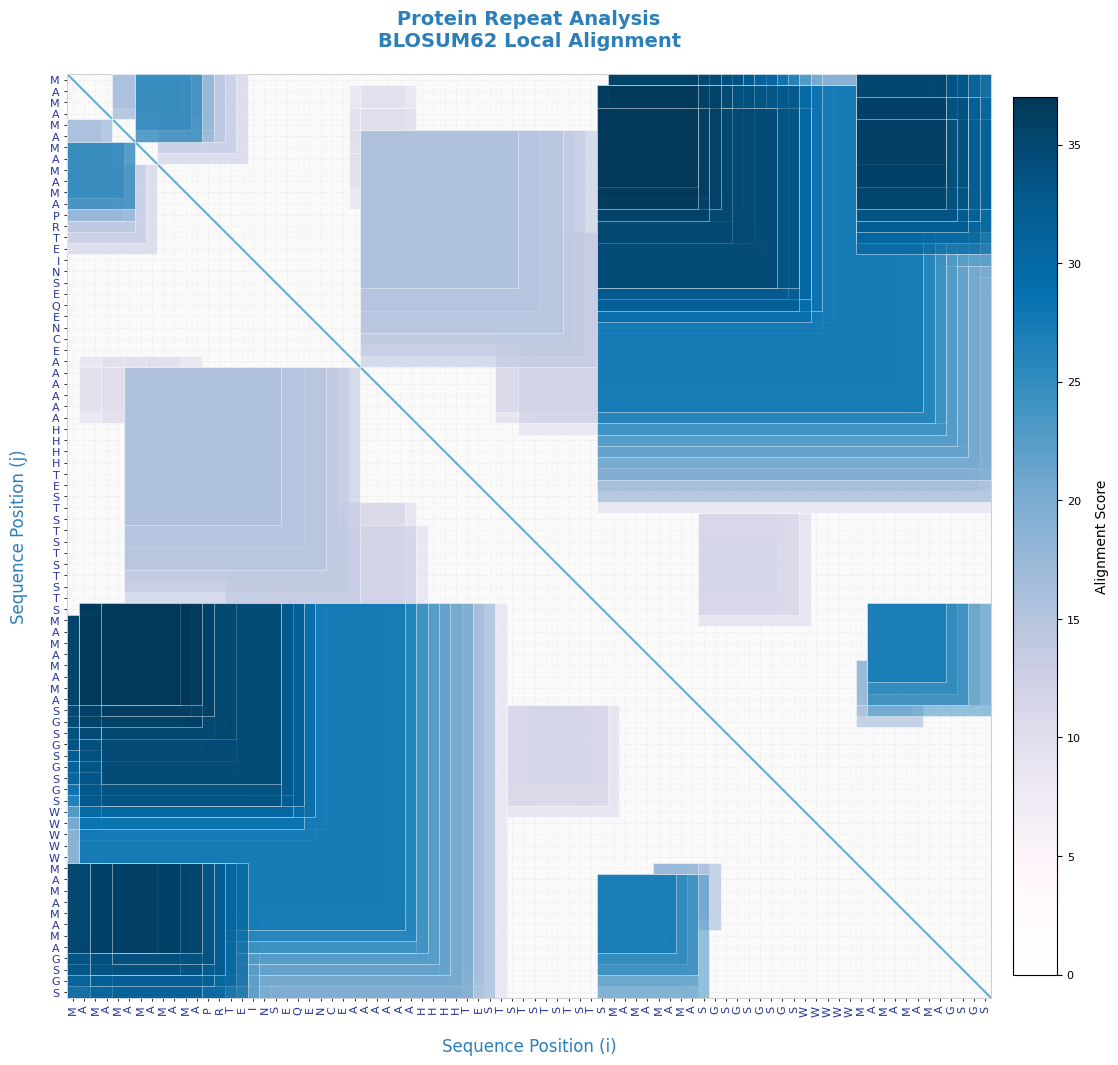

In [21]:
# Example usage
if __name__ == "__main__":
    test_sequence = "MAMAMAMAMAMAPRTEINSEQENCEAAAAAAHHHHTESTSTSTSTSTSMAMAMAMASGSGSGSGSWWWWWMAMAMAMAGSGS"
    try:
        found_repeats = find_repeats(test_sequence, gap_penalty=-8, 
                                    min_score=10, allow_overlap=False)
        print_repeats(found_repeats)
        if found_repeats:
            plot_repeats(found_repeats, test_sequence)
        else:
            print("No repeats found to plot.")
    except ValueError as e:
        print(f"Error: {e}")